In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from UNet import UNet

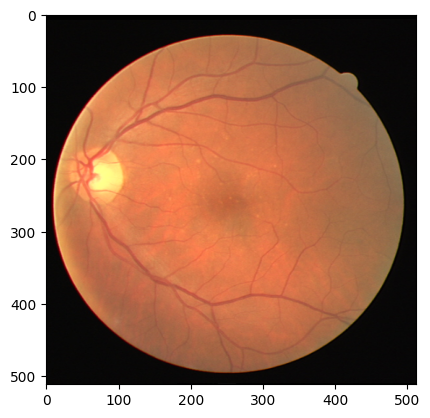

In [5]:
image = Image.open('dataset/train/image/0.png')
plt.imshow(image)